In [2]:
import sys
sys.path.append('/Image-Dehazing/src')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
from torch.utils.data import TensorDataset, DataLoader

from transmission_model import TransmissionModel

In [106]:
file = '/home/shkraboom/Рабочий стол/Image Dehazing/train_data.hdf5'

train_dataset = h5py.File(file, 'r')

haze_images = np.array(train_dataset['haze_image'])
clear_images = np.array(train_dataset['clear_image'])
transmission_value = np.array(train_dataset['transmission_value'])

In [107]:
def predict_batches(model, data, batch_size = 300, device = 'cuda'):
    """
    Function for predicts by batches and gluing them together

    Input: model - model; data - input data; batch_size - size of batch; device - device for calculations
    Output: gluing predictions
    """

    model.to(device)
    model.eval()

    predictions = []

    dataset = TensorDataset(torch.tensor(data.transpose(0, 3, 1, 2)).float())
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            preds = model(batch)
            predictions.append(preds.cpu().numpy())
    
    return np.concatenate(predictions, axis = 0)

In [108]:
model = TransmissionModel()
model.load_state_dict(torch.load('/home/shkraboom/Рабочий стол/Image Dehazing/trans_model_weights.pt'))

haze_images_31x31 = np.pad(haze_images, ((0, 0), (7, 8), (7, 8), (0, 0)), 'symmetric')

nyu_transmission_map = predict_batches(model = model, data = haze_images_31x31)

b = nyu_transmission_map.transpose(0, 2, 3, 1)
b = np.squeeze(b, axis = 3)

transmission_map = b.copy()

haze_images_0_255 = (haze_images * 255.0).astype('uint8')

for i, val in enumerate(b):
    b[i] = model.transmission_refine(haze_images_0_255[i], val)

transmission_map_refine = b.copy()

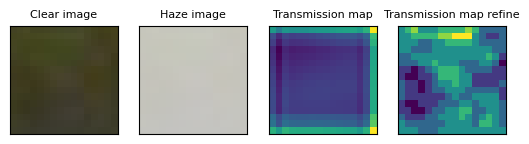

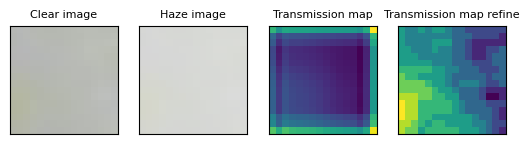

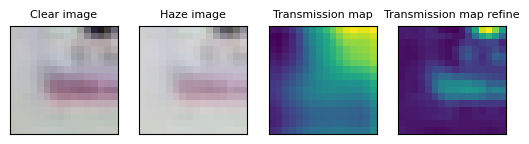

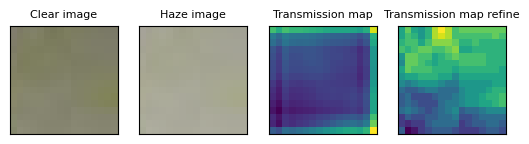

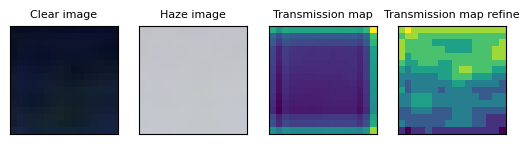

In [109]:
for i in range(5):
    fig, axes = plt.subplots(1, 4)
    axes[0].imshow(clear_images[i])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title('Clear image', size = 8)
    axes[1].imshow(haze_images[i])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('Haze image', size = 8)
    axes[2].imshow(transmission_map[i])
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title('Transmission map', size = 8)
    axes[3].imshow(transmission_map_refine[i])
    axes[3].set_xticks([])
    axes[3].set_yticks([])
    axes[3].set_title('Transmission map refine', size = 8)

In [111]:
train_dataset_refine = h5py.File('train_data_refine.hdf5', 'w')
train_dataset_refine.create_dataset('clear_images', data = clear_images, compression = 9, shuffle = True)
train_dataset_refine.create_dataset('haze_images', data = haze_images, compression = 9, shuffle = True)
train_dataset_refine.create_dataset('transmission_map_refine', data = transmission_map_refine, compression = 9, shuffle = True)
train_dataset_refine.create_dataset('transmission_map', data = transmission_map, compression = 9, shuffle = True)
train_dataset_refine.close()